In [40]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [41]:
df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-k-zelenko/Statistic/lesson_10/hw_aa.csv', sep=';')

In [42]:
#Изучим данные

In [43]:
df.head()

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [44]:
df.experimentVariant.value_counts()

1    63916
0    63102
Name: experimentVariant, dtype: int64

In [45]:
df.version.value_counts()

v2.8.0      82835
v2.9.0      23954
v3.8.0.0    11804
v3.7.4.0     8425
Name: version, dtype: int64

In [46]:
df.purchase.value_counts()

0    122104
1      4914
Name: purchase, dtype: int64

In [47]:
#Разделим данные на 2 группы по варианту эксперимента и проведем A/A-тест чтобы понять, корректно ли работает система сплитования

In [48]:
df1 = df[df.experimentVariant == 0].purchase
df2 = df[df.experimentVariant == 1].purchase

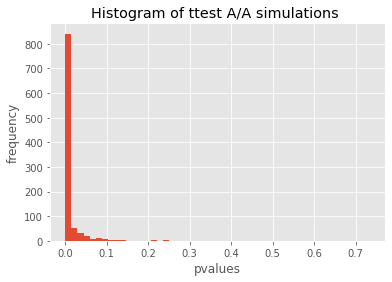

0.936

In [49]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df1.sample(n_s, replace = False).values
    s2 = df2.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

In [50]:
#p-value>0.05, это значит, что в 93,6% случаев сплитования наших данных будут статзначимые различия. Сплит-система сломана.
#Надо найти причину. У нас есть данные о версии мобильного приложения, возможно есть поломка в одной из них, 
#проверим путем разбивки данных по варианту эксперимента и версии приложения с помощью средней.

In [51]:
df.groupby(['experimentVariant', 'version'], as_index=False).agg({'purchase': 'mean'}) 

,experimentVariant,version,purchase
0,0,v2.8.0,0.000993
1,0,v2.9.0,0.074658
2,0,v3.7.4.0,0.059943
3,0,v3.8.0.0,0.057604
4,1,v2.8.0,0.045606
5,1,v2.9.0,0.071304
6,1,v3.7.4.0,0.063018
7,1,v3.8.0.0,0.062848


In [52]:
#Самое заметное различие между вариантами эксперимента видно в версии v2.8.0. Проверим различие с помощью А/А-теста, исключим эту версию, и посмотрим на результат.

In [53]:
df1 = df[(df.experimentVariant == 0) & (df.version != 'v2.8.0')].purchase
df2 = df[(df.experimentVariant == 1) & (df.version != 'v2.8.0')].purchase

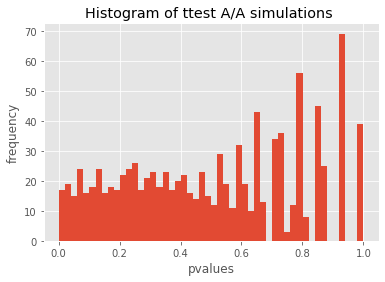

0.045

In [54]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df1.sample(n_s, replace = False).values
    s2 = df2.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

In [55]:
#Видим, что количество ложноположительных случаев примерно равно альфа. Значит, действительно, в наших данных ошибка происходит в версии v2.8.0.
#Но не будем спешить с выводами, а чтобы быть уверенными в нашем утверждении, проверим p-value по каждой версии.

In [56]:
df1_v2_8_0 = df[(df.experimentVariant == 0) & (df.version == 'v2.8.0')].purchase
df2_v2_8_0 = df[(df.experimentVariant == 1) & (df.version == 'v2.8.0')].purchase

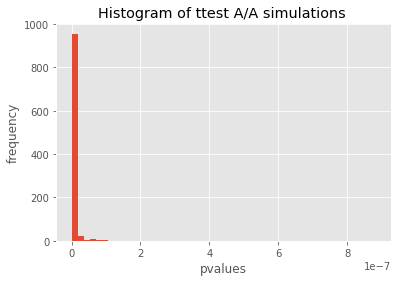

1.0

In [57]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df1_v2_8_0.sample(n_s, replace = False).values
    s2 = df2_v2_8_0.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

In [58]:
#Можно было даже и не исключать эту версию из всех, а сразу сделать этот тест, и было бы понятно, что ошибка кроется здесь. 
#Все равно, проверим остальные версии приложения, чтобы быть уверенными на 100%.

In [59]:
df1_v2_9_0 = df[(df.experimentVariant == 0) & (df.version == 'v2.9.0')].purchase
df2_v2_9_0 = df[(df.experimentVariant == 1) & (df.version == 'v2.9.0')].purchase

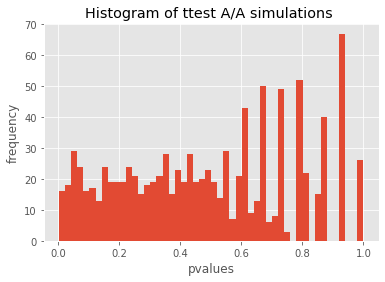

0.043

In [60]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df1_v2_9_0.sample(n_s, replace = False).values
    s2 = df2_v2_9_0.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

In [ ]:
#В версии v2.9.0 все впорядке, p-value близко к 0,05.

In [36]:
df1_v3_7_4_0 = df[(df.experimentVariant == 0) & (df.version == 'v3.7.4.0')].purchase
df2_v3_7_4_0 = df[(df.experimentVariant == 1) & (df.version == 'v3.7.4.0')].purchase

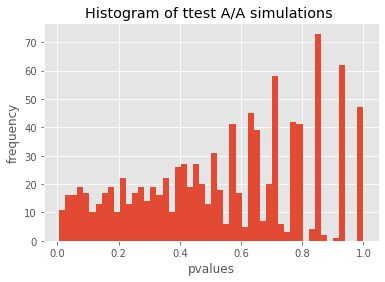

0.031

In [37]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df1_v3_7_4_0.sample(n_s, replace = False).values
    s2 = df2_v3_7_4_0.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

In [ ]:
#p>0,05, сплит-система в версии v3.7.4.0 работает корректно

In [38]:
df1_v3_8_0_0 = df[(df.experimentVariant == 0) & (df.version == 'v3.8.0.0')].purchase
df2_v3_8_0_0 = df[(df.experimentVariant == 1) & (df.version == 'v3.8.0.0')].purchase

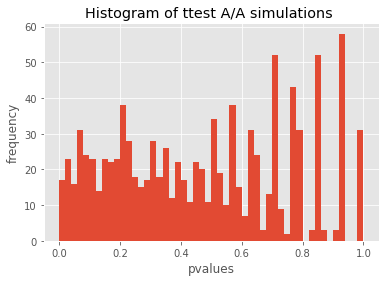

0.05

In [39]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df1_v3_8_0_0.sample(n_s, replace = False).values
    s2 = df2_v3_8_0_0.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

In [ ]:
#И в версии v3.8.0.0 сплит-система работает корректно

In [ ]:
#Делаем вывод, что система сплитования в наших данных работает некорректно. Проанализировав все версии мобильного приложения, нашли ошибку в версии v2.8.0.
#Можем предположить, что это самая старая версия приложения, т.к. они обычно идут по возрастанию цифр в названии.
#Т.к. сплит-система сломана, дальнейшая работа по внедрению экспериментов в эти данные будет неправильная и измеренный эффект от изменений путем А/В-теста тоже будет неправильный.